In [1]:
import numpy as np
import pandas as pd
import pickle
import statistics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import datasets



In [2]:
# Make Dataset File
df = pd.DataFrame()
df_afib = pd.read_csv('AFIB.csv')  # read csv file
df_normal = pd.read_csv('Normal.csv')  # read csv file
df_afib['label'] = ('AFIB')  # add label
df_normal['label'] = ('NORMAL')  # add label
new_df = pd.concat([df_afib, df_normal], axis=0)  # concatenate 2 dataframe
new_df.to_csv('data_extracted.csv', index=False)

In [23]:
import pandas as pd

df = pd.read_csv('data_extracted.csv')
df.head(3)

,maxRR,minRR,meanRR,stdevRR,maxQRS,minQRS,meanQRS,stdevQRS,maxTP,minTP,meanTP,stdevTP,maxPQ,minPQ,meanPQ,stdevPQ,label
0,1.904,0.340,0.633161,0.314340,0.220,0.060,0.099441,0.034978,0.844,0.040,0.241739,0.152545,0.428,0.008,0.093348,0.070379,AFIB
1,1.388,0.380,0.584588,0.179367,0.192,0.056,0.104275,0.028873,0.784,0.040,0.186297,0.122869,0.276,0.008,0.086614,0.043845,AFIB
2,1.128,0.316,0.551222,0.176818,0.248,0.060,0.103074,0.030843,0.500,0.044,0.164710,0.097750,0.320,0.008,0.076523,0.048028,AFIB


In [4]:
df.columns = ['maxRR','minRR','meanRR','stdevRR','maxQRS','minQRS','meanQRS','stdevQRS','maxTP','minTP','meanTP','stdevTP','maxPQ','minPQ','meanPQ','stdevPQ','label']

# Create training and test split
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1:], test_size = 0.3, random_state=1)

# Feature scaling
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# Training / Test Dataframe
cols = ['maxRR','minRR','meanRR','stdevRR','maxQRS','minQRS','meanQRS','stdevQRS','maxTP','minTP','meanTP','stdevTP','maxPQ','minPQ','meanPQ','stdevPQ']

X_train_std = pd.DataFrame(X_train_std, columns=cols)
X_test_std = pd.DataFrame(X_test_std, columns=cols)

forest = RandomForestClassifier()

# Train the mode
forest.fit(X_train_std, y_train.values.ravel())

RandomForestClassifier()

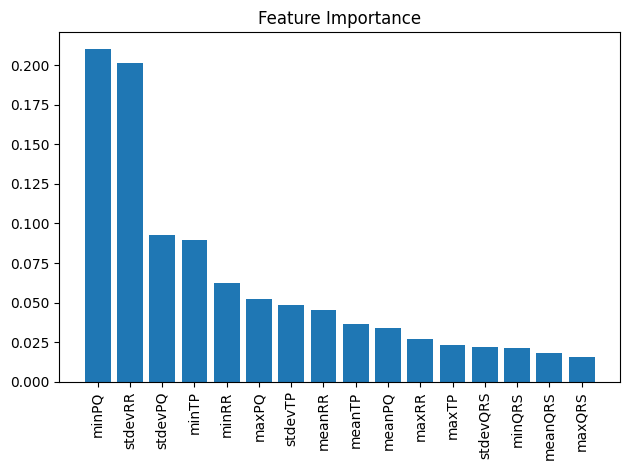

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
 
forest = RandomForestClassifier()
forest.fit(X_train_std, y_train.values.ravel())
importances = forest.feature_importances_

# Sort the feature importance in descending order
sorted_indices = np.argsort(importances)[::-1]
 
feat_labels = df.columns[1:]
# for f in range(X_train.shape[1]):
#     print("%2d) %-*s %f" % (f + 1, 30, feat_labels[sorted_indices[f]], importances[sorted_indices[f]]))

# Show in chart 
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_21984\115849871.py:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


<AxesSubplot: >

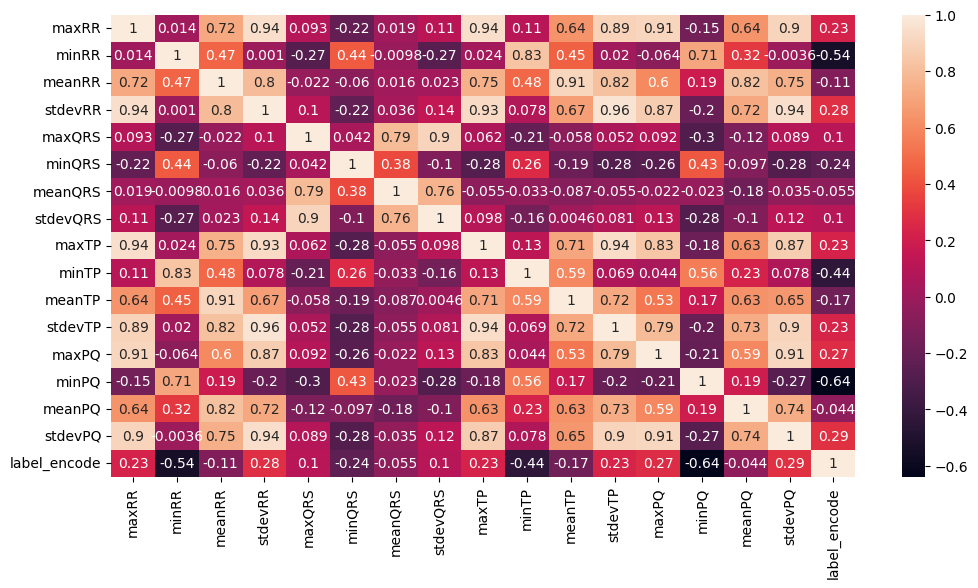

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt 

df['label_encode'] = df['label'].map({
    'NORMAL': 0,
    'AFIB': 1
})

plt.figure(figsize=(12,6))
sns.heatmap(df.corr(), annot=True)

In [7]:
def TrainAndTest(X, y, models):
    
    kf = KFold(n_splits=5, shuffle=True, random_state=100)
    # kf = KFold(n_splits=10, shuffle=False)
    Acc = []
    Sen = []
    Spe = []
    for name, model in models.items():
        pipeline = Pipeline(steps=[('model', model)])
        i = 0
        print(name)
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)

            conf = confusion_matrix(y_test, y_pred)
            TP = conf[0, 0]
            FP = conf[0, 1]
            FN = conf[1, 0]
            TN = conf[1, 1]
            accuracy = (TP + TN) / (TP + FP + FN + TN)
            Acc.append(accuracy)
            sensitivity = (TP) / (TP + FN)
            Sen.append(sensitivity)
            specificity = (TN) / (TN + FP)
            Spe.append(specificity)
            print('accuracy: ', accuracy)
            print('sensitivity: ', sensitivity)
            print('specificity: ', specificity)
            print( )
            i = i + 1
        print('MEAN')
        print('accuracy: ', statistics.mean(Acc))
        print('sensitivity: ', statistics.mean(Sen))
        print('specificity: ', statistics.mean(Spe))
        Acc.clear()
        Sen.clear()
        Spe.clear()
        print('-' * 100)

In [8]:
# df.drop_duplicates(keep='first',inplace=True)
X = df.drop(['label','label_encode','maxTP','minTP','meanTP','stdevTP','maxPQ','minPQ','meanPQ','stdevPQ'], axis=1)
y = df['label_encode']

models = {'Random Forest Classifier': RandomForestClassifier(),
        'Ada Boost Classifier': AdaBoostClassifier(),
        'Gradient Boosting Classifier': GradientBoostingClassifier()}
TrainAndTest(X, y, models)

Random Forest Classifier
accuracy:  0.94375
sensitivity:  0.9710144927536232
specificity:  0.9230769230769231

accuracy:  0.96875
sensitivity:  0.9767441860465116
specificity:  0.9594594594594594

accuracy:  0.9375
sensitivity:  0.9861111111111112
specificity:  0.8977272727272727

accuracy:  0.925
sensitivity:  0.971830985915493
specificity:  0.8876404494382022

accuracy:  0.95625
sensitivity:  0.9620253164556962
specificity:  0.9506172839506173

MEAN
accuracy:  0.94625
sensitivity:  0.973545218456487
specificity:  0.9237042777304949
----------------------------------------------------------------------------------------------------
Ada Boost Classifier
accuracy:  0.9375
sensitivity:  0.9324324324324325
specificity:  0.9418604651162791

accuracy:  0.95625
sensitivity:  0.9545454545454546
specificity:  0.9583333333333334

accuracy:  0.925
sensitivity:  0.9594594594594594
specificity:  0.8953488372093024

accuracy:  0.90625
sensitivity:  0.9324324324324325
specificity:  0.883720930232558

In [9]:
# df.drop_duplicates(keep='first',inplace=True)
X = df.drop(['label','label_encode'], axis=1)
y = df['label_encode']

models = {'Random Forest Classifier': RandomForestClassifier(),
        'Ada Boost Classifier': AdaBoostClassifier(),
        'Gradient Boosting Classifier': GradientBoostingClassifier()}
TrainAndTest(X, y, models)

Random Forest Classifier
accuracy:  0.95625
sensitivity:  0.958904109589041
specificity:  0.9540229885057471

accuracy:  0.96875
sensitivity:  0.9659090909090909
specificity:  0.9722222222222222

accuracy:  0.93125
sensitivity:  0.96
specificity:  0.9058823529411765

accuracy:  0.95625
sensitivity:  0.9736842105263158
specificity:  0.9404761904761905

accuracy:  0.96875
sensitivity:  0.9746835443037974
specificity:  0.9629629629629629

MEAN
accuracy:  0.95625
sensitivity:  0.966636191065649
specificity:  0.9471133434216599
----------------------------------------------------------------------------------------------------
Ada Boost Classifier
accuracy:  0.9625
sensitivity:  0.9722222222222222
specificity:  0.9545454545454546

accuracy:  0.975
sensitivity:  0.9662921348314607
specificity:  0.9859154929577465

accuracy:  0.95
sensitivity:  0.9864864864864865
specificity:  0.9186046511627907

accuracy:  0.95625
sensitivity:  0.9615384615384616
specificity:  0.9512195121951219

accuracy:  

In [10]:
# df.drop_duplicates(keep='first',inplace=True)
X = df.drop(['label','label_encode','maxRR','maxQRS','minQRS','meanQRS','stdevQRS','maxTP','meanTP','meanPQ','meanRR','maxPQ'], axis=1)
y = df['label_encode']

models = {'Random Forest Classifier': RandomForestClassifier(),
        'Ada Boost Classifier': AdaBoostClassifier(),
        'Gradient Boosting Classifier': GradientBoostingClassifier()}
TrainAndTest(X, y, models)

Random Forest Classifier
accuracy:  0.93125
sensitivity:  0.92
specificity:  0.9411764705882353

accuracy:  0.95
sensitivity:  0.9340659340659341
specificity:  0.9710144927536232

accuracy:  0.925
sensitivity:  0.9473684210526315
specificity:  0.9047619047619048

accuracy:  0.9125
sensitivity:  0.9577464788732394
specificity:  0.8764044943820225

accuracy:  0.94375
sensitivity:  0.9176470588235294
specificity:  0.9733333333333334

MEAN
accuracy:  0.9325
sensitivity:  0.9353655785630669
specificity:  0.9333381391638238
----------------------------------------------------------------------------------------------------
Ada Boost Classifier
accuracy:  0.95625
sensitivity:  0.9240506329113924
specificity:  0.9876543209876543

accuracy:  0.95625
sensitivity:  0.9444444444444444
specificity:  0.9714285714285714

accuracy:  0.90625
sensitivity:  0.9333333333333333
specificity:  0.8823529411764706

accuracy:  0.925
sensitivity:  0.958904109589041
specificity:  0.896551724137931

accuracy:  0.9

In [11]:
# df.drop_duplicates(keep='first',inplace=True)
X = df.drop(['label','label_encode','maxRR','maxQRS','minQRS','meanQRS','stdevQRS','maxTP','meanTP','meanPQ','meanRR'], axis=1)
y = df['label_encode']

models = {'Random Forest Classifier': RandomForestClassifier(),
        'Ada Boost Classifier': AdaBoostClassifier(),
        'Gradient Boosting Classifier': GradientBoostingClassifier()}
TrainAndTest(X, y, models)

Random Forest Classifier
accuracy:  0.925
sensitivity:  0.8974358974358975
specificity:  0.9512195121951219

accuracy:  0.9625
sensitivity:  0.945054945054945
specificity:  0.9855072463768116

accuracy:  0.925
sensitivity:  0.9358974358974359
specificity:  0.9146341463414634

accuracy:  0.9375
sensitivity:  0.9859154929577465
specificity:  0.898876404494382

accuracy:  0.93125
sensitivity:  0.9058823529411765
specificity:  0.96

MEAN
accuracy:  0.93625
sensitivity:  0.9340372248574402
specificity:  0.9420474618815557
----------------------------------------------------------------------------------------------------
Ada Boost Classifier
accuracy:  0.94375
sensitivity:  0.9113924050632911
specificity:  0.9753086419753086

accuracy:  0.95625
sensitivity:  0.9444444444444444
specificity:  0.9714285714285714

accuracy:  0.90625
sensitivity:  0.9452054794520548
specificity:  0.8735632183908046

accuracy:  0.91875
sensitivity:  0.9583333333333334
specificity:  0.8863636363636364

accuracy:  

In [12]:
# df.drop_duplicates(keep='first',inplace=True)
X = df.drop(['label','label_encode','maxRR','maxQRS','minQRS','meanQRS','stdevQRS','maxTP','meanPQ'], axis=1)
y = df['label_encode']

models = {'Random Forest Classifier': RandomForestClassifier(),
        'Ada Boost Classifier': AdaBoostClassifier(),
        'Gradient Boosting Classifier': GradientBoostingClassifier()}
TrainAndTest(X, y, models)

Random Forest Classifier
accuracy:  0.93125
sensitivity:  0.92
specificity:  0.9411764705882353

accuracy:  0.96875
sensitivity:  0.9456521739130435
specificity:  1.0

accuracy:  0.925
sensitivity:  0.9473684210526315
specificity:  0.9047619047619048

accuracy:  0.95625
sensitivity:  0.9736842105263158
specificity:  0.9404761904761905

accuracy:  0.9625
sensitivity:  0.9512195121951219
specificity:  0.9743589743589743

MEAN
accuracy:  0.94875
sensitivity:  0.9475848635374226
specificity:  0.9521547080370609
----------------------------------------------------------------------------------------------------
Ada Boost Classifier
accuracy:  0.95625
sensitivity:  0.9466666666666667
specificity:  0.9647058823529412

accuracy:  0.96875
sensitivity:  0.9659090909090909
specificity:  0.9722222222222222

accuracy:  0.91875
sensitivity:  0.9466666666666667
specificity:  0.8941176470588236

accuracy:  0.95625
sensitivity:  0.9390243902439024
specificity:  0.9743589743589743

accuracy:  0.95
sensi

In [13]:
# df.drop_duplicates(keep='first',inplace=True)
X = df.drop(['label','label_encode','maxRR','maxQRS','minQRS','meanQRS','stdevQRS','maxTP'], axis=1)
y = df['label_encode']

models = {'Random Forest Classifier': RandomForestClassifier(),
        'Ada Boost Classifier': AdaBoostClassifier(),
        'Gradient Boosting Classifier': GradientBoostingClassifier()}
TrainAndTest(X, y, models)

Random Forest Classifier
accuracy:  0.95625
sensitivity:  0.9466666666666667
specificity:  0.9647058823529412

accuracy:  0.96875
sensitivity:  0.9555555555555556
specificity:  0.9857142857142858

accuracy:  0.93125
sensitivity:  0.948051948051948
specificity:  0.9156626506024096

accuracy:  0.94375
sensitivity:  0.9605263157894737
specificity:  0.9285714285714286

accuracy:  0.9625
sensitivity:  0.9625
specificity:  0.9625

MEAN
accuracy:  0.9525
sensitivity:  0.9546600972127288
specificity:  0.951430849448213
----------------------------------------------------------------------------------------------------
Ada Boost Classifier
accuracy:  0.96875
sensitivity:  0.96
specificity:  0.9764705882352941

accuracy:  0.9875
sensitivity:  1.0
specificity:  0.9733333333333334

accuracy:  0.94375
sensitivity:  0.961038961038961
specificity:  0.927710843373494

accuracy:  0.95
sensitivity:  0.9493670886075949
specificity:  0.9506172839506173

accuracy:  0.95
sensitivity:  0.95
specificity:  0.9

In [14]:
# df.drop_duplicates(keep='first',inplace=True)
X = df.drop(['label','label_encode','maxQRS','minQRS','meanQRS','stdevQRS','maxTP'], axis=1)
y = df['label_encode']

models = {'Random Forest Classifier': RandomForestClassifier(),
        'Ada Boost Classifier': AdaBoostClassifier(),
        'Gradient Boosting Classifier': GradientBoostingClassifier()}
TrainAndTest(X, y, models)

Random Forest Classifier
accuracy:  0.95625
sensitivity:  0.958904109589041
specificity:  0.9540229885057471

accuracy:  0.9625
sensitivity:  0.945054945054945
specificity:  0.9855072463768116

accuracy:  0.925
sensitivity:  0.9473684210526315
specificity:  0.9047619047619048

accuracy:  0.95
sensitivity:  0.961038961038961
specificity:  0.9397590361445783

accuracy:  0.9375
sensitivity:  0.9375
specificity:  0.9375

MEAN
accuracy:  0.94625
sensitivity:  0.9499732873471157
specificity:  0.9443102351578083
----------------------------------------------------------------------------------------------------
Ada Boost Classifier
accuracy:  0.95625
sensitivity:  0.958904109589041
specificity:  0.9540229885057471

accuracy:  0.98125
sensitivity:  0.9883720930232558
specificity:  0.972972972972973

accuracy:  0.93125
sensitivity:  0.948051948051948
specificity:  0.9156626506024096

accuracy:  0.95625
sensitivity:  0.9615384615384616
specificity:  0.9512195121951219

accuracy:  0.95625
sensiti

In [15]:
# df.drop_duplicates(keep='first',inplace=True)
X = df.drop(['label','label_encode','maxQRS','minQRS','meanQRS','stdevQRS'], axis=1)
y = df['label_encode']

models = {'Random Forest Classifier': RandomForestClassifier(),
        'Ada Boost Classifier': AdaBoostClassifier(),
        'Gradient Boosting Classifier': GradientBoostingClassifier()}
TrainAndTest(X, y, models)

Random Forest Classifier
accuracy:  0.94375
sensitivity:  0.9333333333333333
specificity:  0.9529411764705882

accuracy:  0.96875
sensitivity:  0.9555555555555556
specificity:  0.9857142857142858

accuracy:  0.93125
sensitivity:  0.948051948051948
specificity:  0.9156626506024096

accuracy:  0.95
sensitivity:  0.9863013698630136
specificity:  0.9195402298850575

accuracy:  0.95625
sensitivity:  0.9506172839506173
specificity:  0.9620253164556962

MEAN
accuracy:  0.95
sensitivity:  0.9547718981508936
specificity:  0.9471767318256075
----------------------------------------------------------------------------------------------------
Ada Boost Classifier
accuracy:  0.95625
sensitivity:  0.958904109589041
specificity:  0.9540229885057471

accuracy:  0.98125
sensitivity:  0.9883720930232558
specificity:  0.972972972972973

accuracy:  0.93125
sensitivity:  0.948051948051948
specificity:  0.9156626506024096

accuracy:  0.9625
sensitivity:  0.9620253164556962
specificity:  0.9629629629629629



In [16]:
# df.drop_duplicates(keep='first',inplace=True)
X = df.drop(['label','label_encode','maxQRS','minQRS','meanQRS'], axis=1)
y = df['label_encode']

models = {'Random Forest Classifier': RandomForestClassifier(),
        'Ada Boost Classifier': AdaBoostClassifier(),
        'Gradient Boosting Classifier': GradientBoostingClassifier()}
TrainAndTest(X, y, models)

Random Forest Classifier
accuracy:  0.95625
sensitivity:  0.958904109589041
specificity:  0.9540229885057471

accuracy:  0.96875
sensitivity:  0.9555555555555556
specificity:  0.9857142857142858

accuracy:  0.925
sensitivity:  0.9473684210526315
specificity:  0.9047619047619048

accuracy:  0.95
sensitivity:  0.9733333333333334
specificity:  0.9294117647058824

accuracy:  0.95
sensitivity:  0.95
specificity:  0.95

MEAN
accuracy:  0.95
sensitivity:  0.9570322839061123
specificity:  0.944782188737564
----------------------------------------------------------------------------------------------------
Ada Boost Classifier
accuracy:  0.96875
sensitivity:  0.9726027397260274
specificity:  0.9655172413793104

accuracy:  0.9875
sensitivity:  1.0
specificity:  0.9733333333333334

accuracy:  0.94375
sensitivity:  0.961038961038961
specificity:  0.927710843373494

accuracy:  0.94375
sensitivity:  0.9487179487179487
specificity:  0.9390243902439024

accuracy:  0.95625
sensitivity:  0.9620253164556

In [17]:
# df.drop_duplicates(keep='first',inplace=True)
X = df.drop(['label','label_encode','maxQRS','minQRS'], axis=1)
y = df['label_encode']

models = {'Random Forest Classifier': RandomForestClassifier(),
        'Ada Boost Classifier': AdaBoostClassifier(),
        'Gradient Boosting Classifier': GradientBoostingClassifier()}
TrainAndTest(X, y, models)

Random Forest Classifier
accuracy:  0.9625
sensitivity:  0.9722222222222222
specificity:  0.9545454545454546

accuracy:  0.98125
sensitivity:  0.9772727272727273
specificity:  0.9861111111111112

accuracy:  0.9375
sensitivity:  0.972972972972973
specificity:  0.9069767441860465

accuracy:  0.9625
sensitivity:  0.9866666666666667
specificity:  0.9411764705882353

accuracy:  0.96875
sensitivity:  0.9746835443037974
specificity:  0.9629629629629629

MEAN
accuracy:  0.9625
sensitivity:  0.9767636266876774
specificity:  0.9503545486787621
----------------------------------------------------------------------------------------------------
Ada Boost Classifier
accuracy:  0.96875
sensitivity:  0.9726027397260274
specificity:  0.9655172413793104

accuracy:  0.95625
sensitivity:  0.9545454545454546
specificity:  0.9583333333333334

accuracy:  0.9375
sensitivity:  0.972972972972973
specificity:  0.9069767441860465

accuracy:  0.95
sensitivity:  0.961038961038961
specificity:  0.9397590361445783



In [18]:
# df.drop_duplicates(keep='first',inplace=True)
X = df.drop(['label','label_encode','maxQRS'], axis=1)
y = df['label_encode']

models = {'Random Forest Classifier': RandomForestClassifier(),
        'Ada Boost Classifier': AdaBoostClassifier(),
        'Gradient Boosting Classifier': GradientBoostingClassifier()}
TrainAndTest(X, y, models)

Random Forest Classifier
accuracy:  0.95625
sensitivity:  0.958904109589041
specificity:  0.9540229885057471

accuracy:  0.9625
sensitivity:  0.9550561797752809
specificity:  0.971830985915493

accuracy:  0.925
sensitivity:  0.9722222222222222
specificity:  0.8863636363636364

accuracy:  0.9625
sensitivity:  0.9866666666666667
specificity:  0.9411764705882353

accuracy:  0.9625
sensitivity:  0.9625
specificity:  0.9625

MEAN
accuracy:  0.95375
sensitivity:  0.9670698356506422
specificity:  0.9431788162746223
----------------------------------------------------------------------------------------------------
Ada Boost Classifier
accuracy:  0.95625
sensitivity:  0.958904109589041
specificity:  0.9540229885057471

accuracy:  0.9875
sensitivity:  0.9885057471264368
specificity:  0.9863013698630136

accuracy:  0.95625
sensitivity:  0.9866666666666667
specificity:  0.9294117647058824

accuracy:  0.95625
sensitivity:  0.9615384615384616
specificity:  0.9512195121951219

accuracy:  0.95
sensit

In [22]:
X = df.drop(['label','label_encode','maxRR','maxQRS','minQRS','meanQRS','stdevQRS','maxTP'], axis=1)
y = df['label_encode']
# splitting the X, and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Call the classifier
abc = AdaBoostClassifier()
# Fit the classifier to the training data
model = abc.fit(X_train, y_train)

filename = 'model_ecg_adaboost_tuned.sav'
pickle.dump(abc, open(filename, 'wb'))